# RNN for path-dependent plasticity

[Reference](https://doi.org/10.1016/j.jmps.2020.103972):
Gorji, M. B., Mozaffar, M., Heidenreich, J. N., Cao, J., & Mohr, D. (2020). On the potential of recurrent neural networks for modeling path dependent plasticity. *Journal of the Mechanics and Physics of Solids*, 143, 103972.

Plasticity model: Anisotropic Yld2000-2d with homogeneous anisotropic hardening

ML model: Gated recurrent units (GRU) + fully-connected layer (for plane stress only?)

### FCNN model for UT with reveral loading

In [2]:
import numpy as np

def interpolate(xin, yin, reverse=False):

    strain = np.linspace(min(xin), max(xin), 1000) if not reverse else np.linspace(max(xin), min(xin), 1000)
    stress = np.interp(strain, xin, yin) if not reverse else np.interp(strain, xin[::-1], yin[::-1])

    return strain, stress

(2000,)


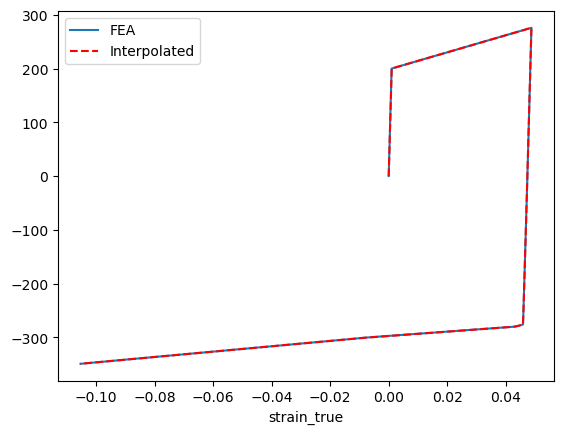

In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

excel_fpath = r"C:\Users\shipi\OneDrive\Research_sci_ML\Reproduction_Mohr_2020_JMPS.xlsx"
sheet = 'UT w reversal'
df = pd.read_excel(excel_fpath, sheet_name=sheet, header=9, usecols='F:P')

df['RF2'] = df['RF2 Node 3'] + df['RF2 Node 4']
df['U2'] = df['U2 Node 3']

df['strain_true'] = np.log(1+df['U2'])
df['stress_true'] = df['RF2'] * (1+df['U2'])

ind_max = df['stress_true'].idxmax()
strain1, stress1 = interpolate(df['strain_true'][:ind_max+1], df['stress_true'][:ind_max+1])
strain2, stress2 = interpolate(df['strain_true'][ind_max:], df['stress_true'][ind_max:], reverse=True)
strain = np.concatenate((strain1, strain2))
stress = np.concatenate((stress1, stress2))
strain_inc = np.diff(strain)
strain_sum = np.cumsum(abs(strain_inc))
strain_sum = np.concatenate(([0], strain_sum))  # Add zero at the beginning
print(strain_sum.shape)

fig, ax = plt.subplots()
df.plot(x='strain_true', y='stress_true', ax=ax, label='FEA')
ax.plot(strain, stress, label='Interpolated', color='r', linestyle='--')
ax.legend()


#### Define the model architecture

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

class Net(nn.Module):

    def __init__(self, n_hl, n_npl):
        super(Net, self).__init__()
        self.nn_stack = nn.Sequential(
            nn.Linear(2, n_npl),
            nn.Tanh(),
            *[nn.Sequential(nn.Linear(n_npl, n_npl), nn.Tanh()) for _ in range(n_hl)],
            nn.Linear(n_npl, 1)
        )

    def forward(self, input):
        output = self.nn_stack(input)
        return output

def train(X, y, batch_size, model, loss_fn, optimizer):

    size = len(X)
    model.train()
    X, y = shuffle(X, y)
    X_batch = torch.tensor(X, dtype=torch.float32).view(batch_size, -1, 2)
    y_batch = torch.tensor(y, dtype=torch.float32).view(batch_size, -1, 1)
    print('X_batch shape:', X_batch.shape)
    for batch, (X, y) in enumerate(zip(X_batch, y_batch)):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch%100 == 0:
            loss, current = loss.item(), (batch+1)*len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')

def test(X, y, model, loss_fn):
    size = len(X)
    model.eval()
    test_loss = 0
    X_batch = torch.tensor(X, dtype=torch.float32)
    y_batch = torch.tensor(y, dtype=torch.float32)
    with torch.no_grad():
        for X, y in zip(X_batch, y_batch):
            X, y = X.to(device).view(1, -1), y.to(device).view(1, -1)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= size
    print(f'Avg loss: {test_loss:>8f} \n')
    return test_loss



Using cuda device


(2000, 2)
(2000,)
(1600, 2)
Epoch 1
-------------------------------
X_batch shape: torch.Size([64, 25, 2])
loss: 68992.453125  [   25/ 1600]
Avg loss: 75278.018630 

Epoch 2
-------------------------------
X_batch shape: torch.Size([64, 25, 2])
loss: 73845.515625  [   25/ 1600]
Avg loss: 75495.844947 

Epoch 3
-------------------------------
X_batch shape: torch.Size([64, 25, 2])
loss: 77673.359375  [   25/ 1600]
Avg loss: 75344.937960 

Epoch 4
-------------------------------
X_batch shape: torch.Size([64, 25, 2])
loss: 73511.617188  [   25/ 1600]
Avg loss: 75358.917579 

Epoch 5
-------------------------------
X_batch shape: torch.Size([64, 25, 2])
loss: 71749.226562  [   25/ 1600]
Avg loss: 75514.163503 

Epoch 6
-------------------------------
X_batch shape: torch.Size([64, 25, 2])
loss: 72693.070312  [   25/ 1600]
Avg loss: 75284.121848 

Epoch 7
-------------------------------
X_batch shape: torch.Size([64, 25, 2])
loss: 77895.656250  [   25/ 1600]
Avg loss: 75266.294263 

Epoch 

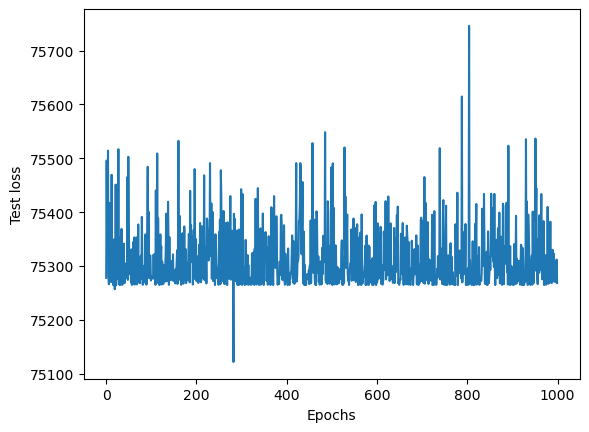

In [56]:
from sklearn.model_selection import train_test_split

model = Net(n_hl=2, n_npl=20).to(device)
# print(model)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
epochs = 1000
batch_size = 64
test_loss = []
strain_inp = np.vstack((strain, strain_sum)).T
print(strain_inp.shape)
print(stress.shape)
x_train, x_test, y_train, y_test = train_test_split(strain_inp, stress, train_size=0.8)
print(x_train.shape)
for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------------')
    train(x_train, y_train, batch_size, model, loss_fn, optimizer)
    test_loss.append(test(x_test, y_test, model, loss_fn))

fig, ax = plt.subplots()
ax.plot(test_loss, label='Test loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Test loss')
print('Done!')


### GRU + FCNN model

In [ ]:
import torch
import torch.nn as nn

class GRU_FCNN(nn.Module):
    def __init__(self, input_size, gru_hidden_size, num_gru_layers, fcnn_hidden_sizes, output_size, dropout_prob=0.0):
        super(GRU_FCNN, self).__init__()
        self.gru = nn.GRU(input_size, gru_hidden_size, num_gru_layers, batch_first=True, dropout=dropout_prob)
        self.fcnn_layers = nn.ModuleList()

        # Add FCNN layers
        input_fcnn_size = gru_hidden_size
        for hidden_size in fcnn_hidden_sizes:
            self.fcnn_layers.append(nn.Linear(input_fcnn_size, hidden_size))
            self.fcnn_layers.append(nn.ReLU())
            input_fcnn_size = hidden_size

        self.fcnn_layers.append(nn.Linear(input_fcnn_size, output_size))

    def forward(self, x):
        # GRU layer
        gru_out, _ = self.gru(x)

        # Take the output from the last time step
        fcnn_in = gru_out[:, -1, :]

        # FCNN layers
        for layer in self.fcnn_layers:
            fcnn_in = layer(fcnn_in)

        return fcnn_in